# Exploratory Data Analysis (EDA) 

**We will analyse the dataset to identify:**

1. Missing values
2. Numerical variables
3. Distribution of the numerical variables
4. Outliers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_df_with_datetime(filepath, datetime_col, delimiter=','):
    # loads a dataframe, converts datetime column into datetime in UTC and sets it as an index
    df = pd.read_csv(filepath, delimiter=delimiter)
    df[datetime_col] = pd.to_datetime(df[datetime_col], utc=True)
    df = df.set_index(pd.DatetimeIndex(df[datetime_col], dayfirst=True))
    df = df.drop(columns=datetime_col)
    return df

In [3]:
# for this notebook let's load the initial dataframe:
filepath = '../datasets/initial_dataframe.csv'
datetime_col = 'datetime_converted'
df = load_df_with_datetime(filepath, datetime_col, delimiter=',')

## Missing values
Let's find out how many variables contain missing values

In [4]:
vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 0]

#percentage of missing values
df[vars_with_na].isnull().mean()

Cloud amount (1/8)                0.001929
Pressure (msl) (hPa)              0.001458
Relative humidity (%)             0.001458
Precipitation intensity (mm/h)    0.003588
Snow depth (cm)                   0.015520
Air temperature (degC)            0.118061
Dew-point temperature (degC)      0.037948
Horizontal visibility (m)         0.022024
Wind direction (deg)              0.006145
Gust speed (m/s)                  0.005966
Wind speed (m/s)                  0.006145
Value (kWh)                       0.015251
Global radiation (W/m2)           0.000763
dtype: float64

In [5]:
len(df.columns)-len(df[vars_with_na].columns)

0

Every variable has some missing columns, we would need to address this situation when doing Feature engineering in the __feature_engineering__ notebook.

Since we have around 5 years of hourly data, we get rid of those NaN values of variables that have less than 5% missing values. Air temperateur has more than 10% of values missing. We will try to get those values from a nearby station.

## Numerical variables

In [38]:
num_vars = [var for var in df.columns if df[var].dtypes !='O']
print('Num of numerical variables: %s, out of total: %s' % (len(num_vars), len(df.columns)))

Num of numerical variables: 13, out of total: 13


__Temporal dependency__

Solar production is dependent on time. The time that the Sun spends above the horizon in our timezone varies throughtout the year, as the Earth's axes is tilted in different times from 22.1 to 24.5 degrees. Thus, we would need to capture that dependency in some of the variables.

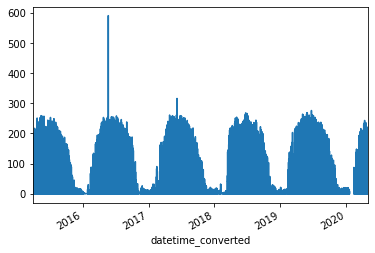

In [41]:
df['Value (kWh)'].plot();

It is clearly periodic during a year. On a side note, we need to take care of those outlier values.

"In Suvilahti solar power plant there are 1 194 solar panels. The output of the panels is 285 W.", citing their website. 

1194*285/1000 = 340.29 kW of installed power, thus values over that cannot possibly happen.

Our index is __DatetimeIndex__, I believe we will create several variables from that to indicate:
* Hour of the day
* Day of the year

Global radiation is a function of these variables and captures the temporal dependency of datetime and target variable.

__Discrete variables__

In [44]:
discrete_vars = [var for var in num_vars if len(df[var].unique())<20]
print('Num of discrete variables: %s, out of numerical: %s' % (len(discrete_vars), len(num_vars)))

Num of discrete variables: 1, out of numerical: 13


In [46]:
discrete_vars

['Cloud amount (1/8)']

Cloud  amount contribution to the target variable:

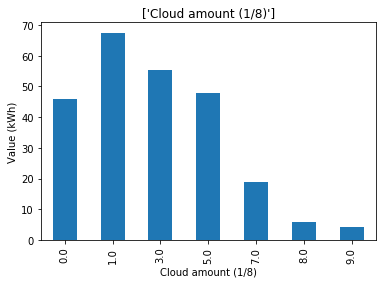

In [49]:
def analyse_discrete(df, var, target):
    df = df.copy()
    df.groupby(var)[target].mean().plot.bar()
    plt.title(var)
    plt.ylabel(str(target))
    plt.show()

analyse_discrete(df, var=['Cloud amount (1/8)'], target='Value (kWh)')

There is a relationship, it also makes sense, as the more clouds, the less radiation coming on our PV panels.

__Continuous variables__

In [50]:
#we consider all the rest of the variables continuous
cont_vars = [var for var in num_vars if var not in discrete_vars]

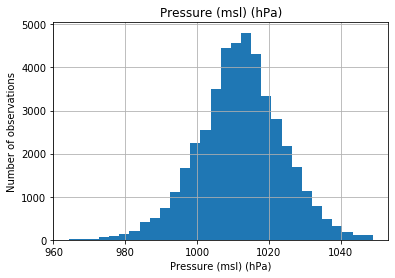

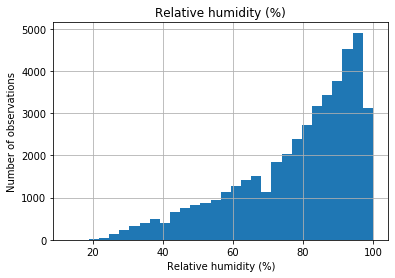

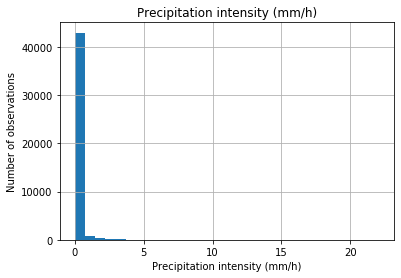

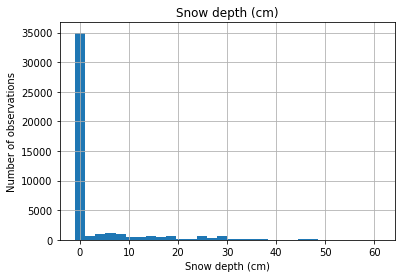

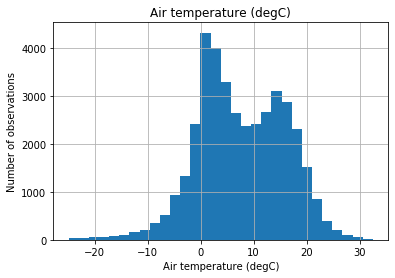

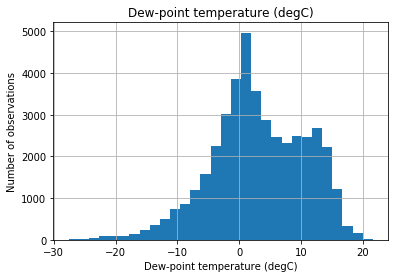

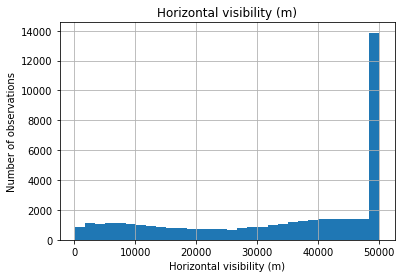

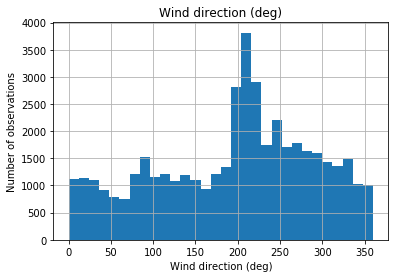

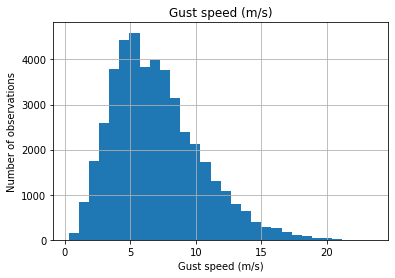

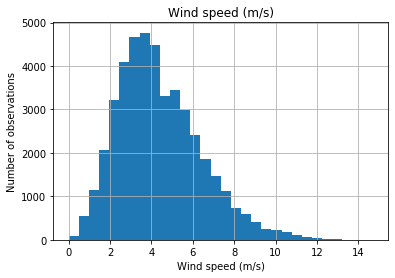

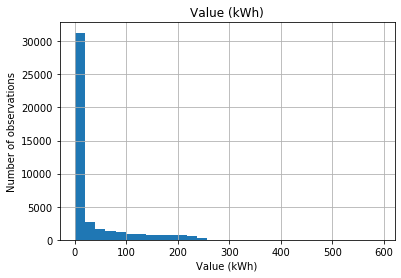

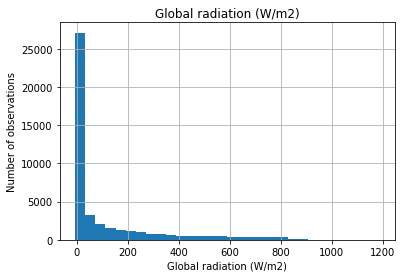

In [53]:
def analyse_continuous(df, var):
    df = df.copy()
    df[var].hist(bins=30)
    plt.ylabel('Number of observations')
    plt.xlabel(var)
    plt.title(var)
    plt.show()
    
for var in cont_vars:
    analyse_continuous(df, var)

All but one variable are not normally distributed, including the target - 'Value (kWh)'

If we are going to use linear models in our prediction, we would have to account for these non-Gaussian distributions and would need to transform variables during the feature engineering step. However, I was planning to use Random Forest decision tree model in the first place and compare it to Neural Networks with Tensorflow. Perhaps a comparison with a linear model would not hurt.

Let's see if a logarithmic transformation would help to return values that follow a normal distribution

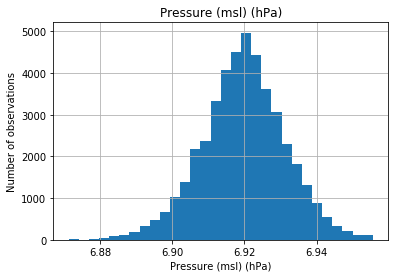

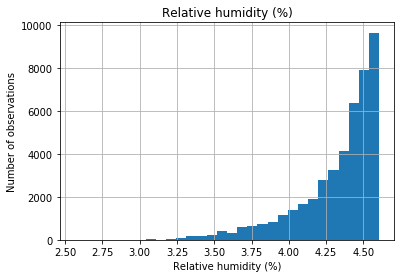

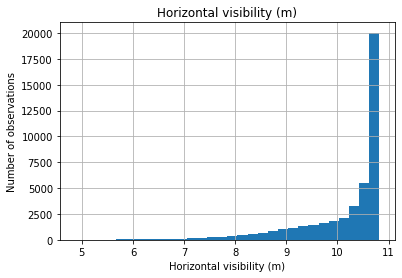

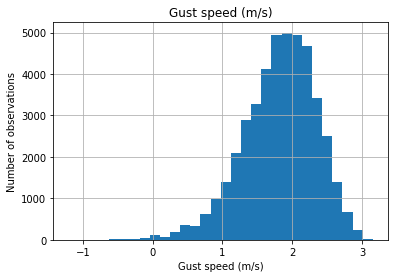

In [62]:
def analyse_transformed_continuous(df, var):
    df = df.copy()

    # log does not take 0 or negative values, so let's be
    # careful and skip those variables
    if any(df[var] <= 0):
        pass
    else:
        # log transform the variable
        df[var] = np.log(df[var])
        df[var].hist(bins=30)
        plt.ylabel('Number of observations')
        plt.xlabel(var)
        plt.title(var)
        plt.show()


for var in cont_vars:
    analyse_transformed_continuous(df, var)

It is not going to transform the target variable to follow a gaussian, as a large part of values in winter is 0 when the sun is not up.

It helps the wind speed, but not so much the others. We will try other variations in __feature_engineering__ notebook.

## Outliers

Extreme values may affect the performance of a linear model. We also have seen at least two large outliers in target variable, which we will have to accomodate for in __feature_engineering__ notebook.

## Correlations

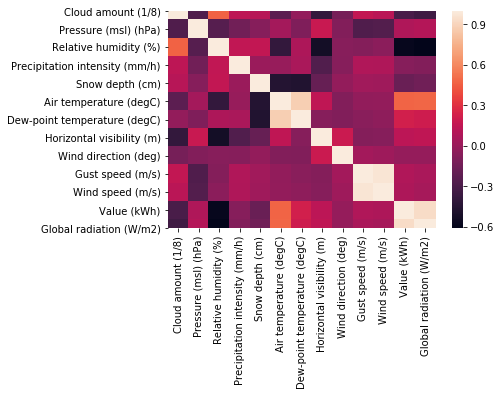

In [68]:
import seaborn as sns
correlation = df.corr()
sns.heatmap(correlation);

In [71]:
correlation

,Cloud amount (1/8),Pressure (msl) (hPa),Relative humidity (%),Precipitation intensity (mm/h),Snow depth (cm),Air temperature (degC),Dew-point temperature (degC),Horizontal visibility (m),Wind direction (deg),Gust speed (m/s),Wind speed (m/s),Value (kWh),Global radiation (W/m2)
Cloud amount (1/8),1.000000,-0.275976,0.466687,0.141910,0.116174,-0.225267,-0.014596,-0.394756,-0.125321,0.158615,0.131155,-0.298928,-0.344342
Pressure (msl) (hPa),-0.275976,1.000000,-0.249606,-0.144036,-0.063810,0.049643,-0.088872,0.188008,-0.079686,-0.273833,-0.258589,0.087624,0.106450
Relative humidity (%),0.466687,-0.249606,1.000000,0.156600,0.157897,-0.391281,0.081787,-0.522407,-0.056954,-0.068986,-0.046986,-0.583449,-0.609641
Precipitation intensity (mm/h),0.141910,-0.144036,0.156600,1.000000,0.007292,-0.004616,0.067148,-0.264056,-0.066600,0.094050,0.087688,-0.065176,-0.076943
Snow depth (cm),0.116174,-0.063810,0.157897,0.007292,1.000000,-0.458089,-0.469098,-0.184454,-0.013983,0.032123,0.029508,-0.174126,-0.149145
Air temperature (degC),-0.225267,0.049643,-0.391281,-0.004616,-0.458089,1.000000,0.879857,0.145678,-0.076455,-0.019433,-0.016882,0.475916,0.478134
Dew-point temperature (degC),-0.014596,-0.088872,0.081787,0.067148,-0.469098,0.879857,1.000000,-0.063855,-0.087627,-0.050971,-0.033627,0.220745,0.201966
Horizontal visibility (m),-0.394756,0.188008,-0.522407,-0.264056,-0.184454,0.145678,-0.063855,1.000000,0.189715,-0.070756,-0.067958,0.134990,0.145491
Wind direction (deg),-0.125321,-0.079686,-0.056954,-0.066600,-0.013983,-0.076455,-0.087627,0.189715,1.000000,0.042298,0.023635,-0.006473,-0.007480
Gust speed (m/s),0.158615,-0.273833,-0.068986,0.094050,0.032123,-0.019433,-0.050971,-0.070756,0.042298,1.000000,0.969795,0.088737,0.065945


We see that our target variable __Value (kWh)__ has the most correlation with:
* Global Radiation (0.93), Relative Humidity (-0.58), Air Temperature (0.47)

__Global Radiation__:
* Air Temperature (0.47), Relative Humidity (-0.61)

__Wind Speed__ and __Gust Speed__ - highly correlated, perhaps redundant features.

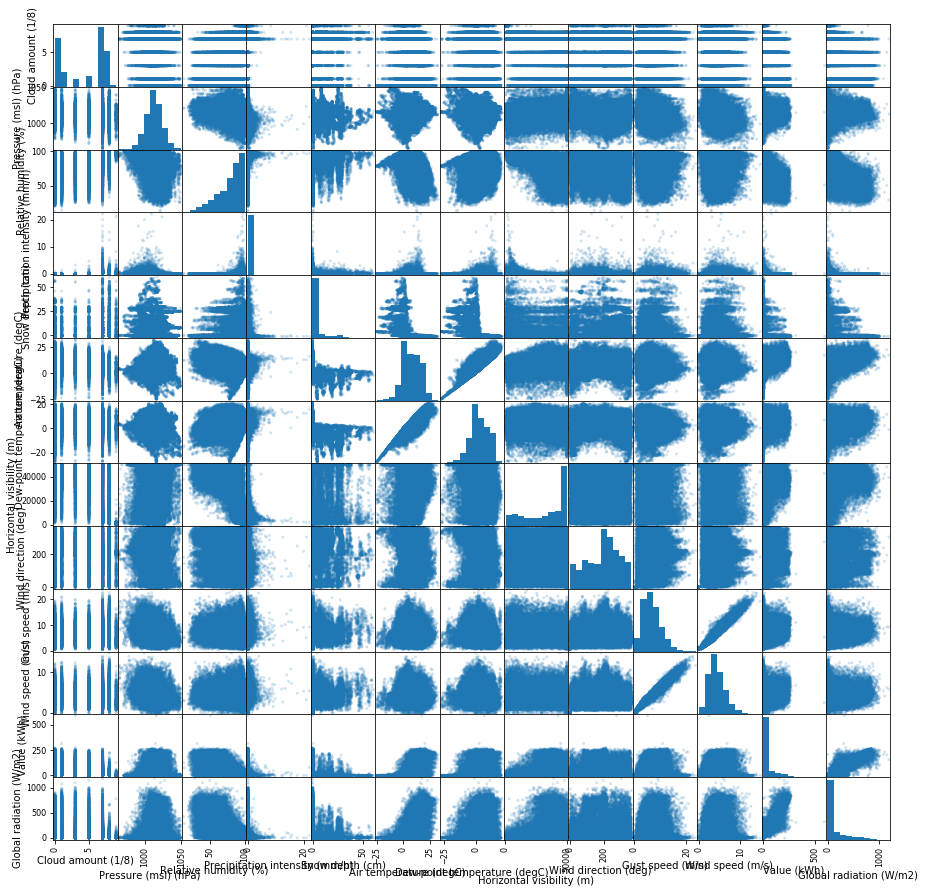

In [74]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(15,15));

Some ideas:
* Global radiation has some sort of relation ship with cloud amount above a certain value. Perhaps it is better to divide cloud amount into fewer categories.
* Wind speed and wind gust might be redundant variables. Maybe it is better to get rid of one of them.
* Target variable has high correlation with the global radiation.

## Extra data

### FMI API recieved data

Let's check which data we recieve from FMI API observation data for our location and see which data we actually have in our data set. Thus, we can segregate columns we don't need and spare some time in feature engineering.

There are several apps to use for this matter, e.g. fmi.py and fmi_weather. Here, we selected fmi_weather for they have a more open licensing. From https://github.com/kipe/fmi

>pip install fmi_weather

If we look into the code in https://github.com/kipe/fmi/blob/master/fmi/observation.py:

#### Table comparison of data values

|                   Parameter                  | Downloaded data | API return |
|:--------------------------------------------:|:---------------:|:--------:|
|                     time                     |        +        |     +    |
|                  temperature                 |        +        |     +    |
|                  wind speed                  |        +        |     +    |
|                wind direction                |        +        |     +    |
|                   wind gust                  |        +        |     +    |
|                   Humidity                   |        +        |     +    |
|                cloud coverage                |        +        |     +    |
|                   pressure                   |        +        |     +    |
|                   dew point                  |        +        |     +    |
|                 precipitation                |        -        |     +    |
|               precipitation 1h               |        +        |     +    |
|         radiation_global_accumulation        |        +        |     +    |
|       radiation_long_wave_accumulation       |        -        |     +    |
|  radiation_netsurface_long_wave_accumulation |        -        |     +    |
| radiation_netsurface_short_wave_accumulation |        -        |     +    |
|        radiation_diffuse_accumulation        |        -        |     +    |
|                weather_symbol                |        -        |     +    |
|                  snow depth                  |        +        |     -    |
|             horizontal visibility            |        +        |     -    |

Thus, we will straight remove the columns in the data that are not a part of the weather API forecast:

* snow depth
* horizontal visibility

There is also an alternative way to calculate theoretical maximum of global radiation depending on time of the day and day of the year. It can be done with theoretical models: 

* http://sgemfinalreport.fi/files/WP611_photovoltaics%20HP%20Hellman.pdf
* https://hal.archives-ouvertes.fr/hal-00361373/document

The code is captured in __azimuth_one_script.py__ with __calc_global_irrad__ function, let's test that.

In [75]:
from azimuth_one_script import *
longtitude = 24.9693
latitude = 60.1867
delta_GMT = 0

In [77]:
df['day_of_the_year'] = df.index.dayofyear
df['hour'] =  df.index.hour
df['calc_global_irrad'] = df.apply(lambda x: calc_glob_irrad(N=x['day_of_the_year'],time=x['hour']),axis=1)

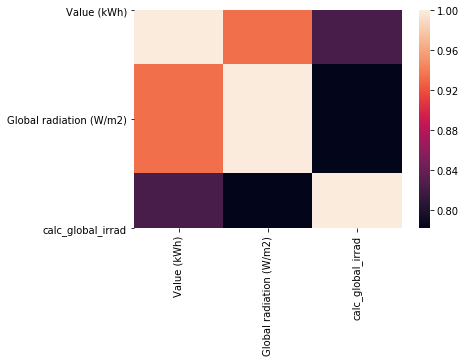

In [78]:
#let's see the correlations
cols = ['Value (kWh)', 'Global radiation (W/m2)', 'calc_global_irrad']
corr = df[cols].corr()
sns.heatmap(corr)

In [79]:
corr

,Value (kWh),Global radiation (W/m2),calc_global_irrad
Value (kWh),1.000000,0.934374,0.823792
Global radiation (W/m2),0.934374,1.000000,0.781825
calc_global_irrad,0.823792,0.781825,1.000000


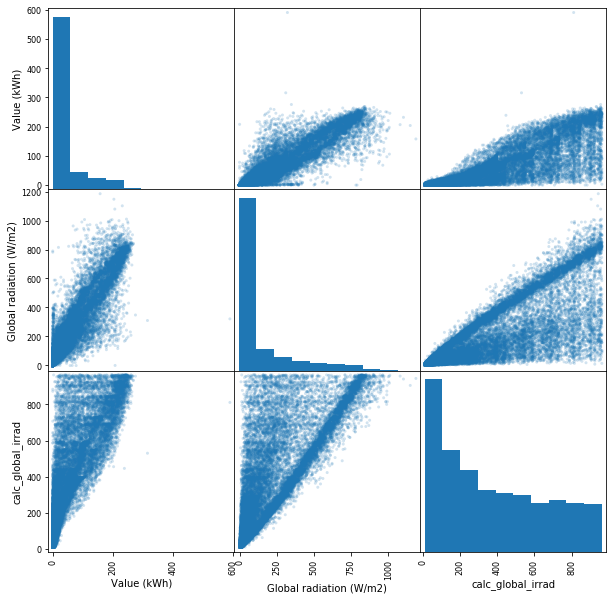

In [80]:
pd.plotting.scatter_matrix(df[cols], alpha=0.2, figsize=(10,10));

FMI values have slightly larger correlation, thus, we will use them. However, if, for some reason, the forecasted variable would not work well, this calculated value can be a substitute.

### Missing values in Air temperature.
Air temperature is missing a large chunk of data. Let's see if we can get a workaround on that.

There is no temperature available from Kumpula for almost a year. There are several options how to deal with it:

1. Remove these values completely. Then, we lose almost 8760 values, approximately
2. Impute those values from somewhere else. For example from the data from a nearby station with another two options
 - Completely pasting them (copy paste, quite irresponsible, but given that there is a about 3km from station to station
 - Creating some sort of model for imputation, which requires more data
 
Therefore, I have predownloaded the Kaisaniemi (the next closest station) Air temperature and Dew point temperature for 2018-2019. We see later what happens.

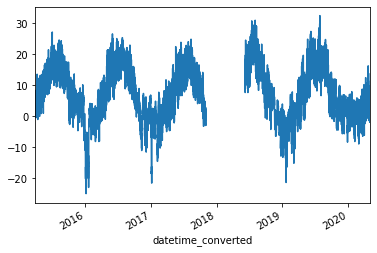

In [81]:
df['Air temperature (degC)'].plot()

Let's see if we can use Kaisaniemi values in the imputation later.

In [84]:
#let's load  the data
df_kaisaniemi1 = pd.read_csv('../datasets/kaisaniemi_17_18.csv')
df_kaisaniemi2 = pd.read_csv('../datasets/kaisaniemi_18_19.csv')
df_kaisaniemi = pd.concat([df_kaisaniemi1,df_kaisaniemi2],axis=0)

In [85]:
df_kaisaniemi

,Year,m,d,Time,Time zone,Air temperature (degC),Dew-point temperature (degC)
0,2017,5,1,00:00,UTC,3.3,0.3
1,2017,5,1,01:00,UTC,3.1,0.5
2,2017,5,1,02:00,UTC,3.4,0.2
3,2017,5,1,03:00,UTC,3.2,0.8
4,2017,5,1,04:00,UTC,4.0,0.3
...,...,...,...,...,...,...,...
8756,2019,4,30,20:00,UTC,5.4,-1.1
8757,2019,4,30,21:00,UTC,5.4,-1.3
8758,2019,4,30,22:00,UTC,5.1,-0.4
8759,2019,4,30,23:00,UTC,5.0,-0.3


In [86]:
df_kaisaniemi['datetime'] = df_kaisaniemi['Year'].astype(str)+'-'+df_kaisaniemi['m'].astype(str)+'-'+df_kaisaniemi['d'].astype(str)+' '+ df_kaisaniemi['Time'].astype(str)
df_kaisaniemi['datetime_converted'] = pd.to_datetime(df_kaisaniemi['datetime'], utc=True)
df_kaisaniemi = df_kaisaniemi.set_index(pd.DatetimeIndex(df_kaisaniemi['datetime_converted'],dayfirst=True))

In [96]:
df_kaisaniemi = df_kaisaniemi.drop(columns=['Year','m','d','Time','Time zone','datetime','datetime_converted'])

KeyError: "['Year' 'm' 'd' 'Time' 'Time zone' 'datetime' 'datetime_converted'] not found in axis"

In [98]:
df_kaisaniemi.columns = ['Air_temp_kaisa', 'Dew-point_kaisa']

In [99]:
# slices: 1-5-2017 -> 4-30-2019
slice_start = '2017-05-01 00:00'
slice_end = '2019-05-01 00:00'
df_slice = df[(df.index>=slice_start)&(df.index<=slice_end)]

In [102]:
df_kaisaniemi

,Air_temp_kaisa,Dew-point_kaisa
datetime_converted,,
2017-05-01 00:00:00+00:00,3.3,0.3
2017-05-01 01:00:00+00:00,3.1,0.5
2017-05-01 02:00:00+00:00,3.4,0.2
2017-05-01 03:00:00+00:00,3.2,0.8
2017-05-01 04:00:00+00:00,4.0,0.3
...,...,...
2019-04-30 20:00:00+00:00,5.4,-1.1
2019-04-30 21:00:00+00:00,5.4,-1.3
2019-04-30 22:00:00+00:00,5.1,-0.4


In [103]:
cols_temp =['Air temperature (degC)', 'Dew-point temperature (degC)']
df_concat = pd.concat([df_slice[cols_temp],df_kaisaniemi],axis=1)
df_concat.head()

,Air temperature (degC),Dew-point temperature (degC),Air_temp_kaisa,Dew-point_kaisa
datetime_converted,,,,
2017-05-01 00:00:00+00:00,2.5,-0.1,3.3,0.3
2017-05-01 01:00:00+00:00,2.6,-0.1,3.1,0.5
2017-05-01 02:00:00+00:00,2.6,-0.8,3.4,0.2
2017-05-01 03:00:00+00:00,2.8,0.0,3.2,0.8
2017-05-01 04:00:00+00:00,3.7,-0.1,4.0,0.3


In [104]:
corr = df_concat.corr()
corr

,Air temperature (degC),Dew-point temperature (degC),Air_temp_kaisa,Dew-point_kaisa
Air temperature (degC),1.000000,0.881166,0.997111,0.894278
Dew-point temperature (degC),0.881166,1.000000,0.914650,0.996787
Air_temp_kaisa,0.997111,0.914650,1.000000,0.905365
Dew-point_kaisa,0.894278,0.996787,0.905365,1.000000


Correlations are very large. Maybe we could use this data straight for imputations.

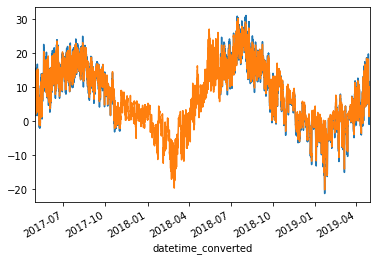

In [105]:
df_concat['Air temperature (degC)'].plot()
df_concat['Air_temp_kaisa'].plot()

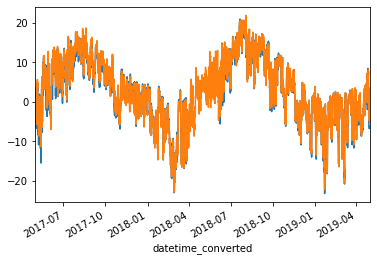

In [106]:
df_concat['Dew-point temperature (degC)'].plot()
df_concat['Dew-point_kaisa'].plot()

This way we will not lose almost a year of data

We tackle this and all the previous things in the __feature_engineering__ notebook

# Done here!